<IPython.core.display.Javascript object>


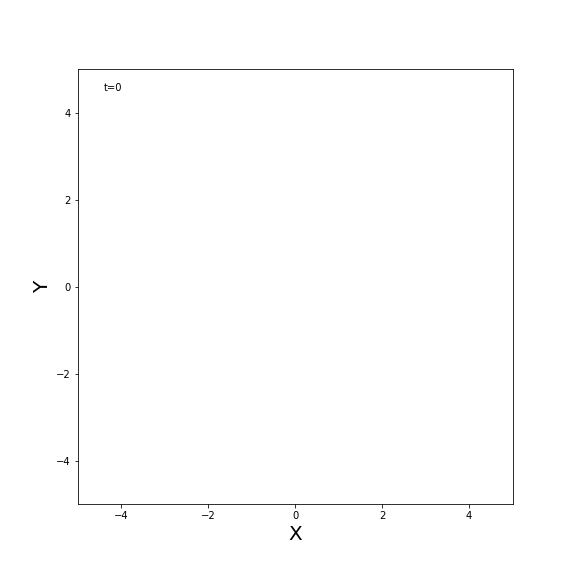

In [39]:
# Worldの描画
from sys import path
path.append('../src')
import importlib

import worlds
import robots
import agents
    
def reload():
    importlib.reload(worlds)
    importlib.reload(robots)
    importlib.reload(agents)

reload()

world = worlds.World(debuggable=False)
world.draw()

<IPython.core.display.Javascript object>


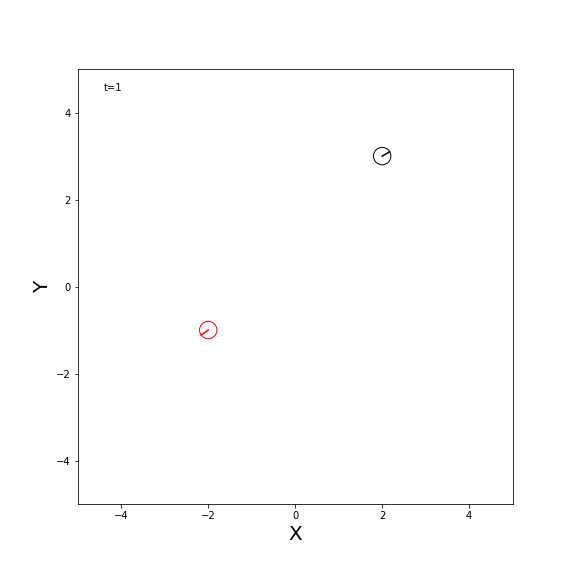

In [40]:
# ロボットを描画
import numpy as np
from math import pi
reload()

world = worlds.World(debuggable=False)

robot1 = robots.IdealRobot(np.array([2., 3., pi / 6.]).T, color='black')
robot2 = robots.IdealRobot(np.array([-2., -1., pi / 5. * 6.]).T, color='red')

world.append(robot1)
world.append(robot2)

world.draw()

制御司令を与えてみる

- 前方方向の速度$v$[m/s]
- ロボット中心の角速度$\omega$[rad/s]

それらを含むベクトルを制御指令とする

$$
{\bf u} = \left(
    \begin{array}{c}
            v \\
            \omega
    \end{array}
\right) \\
$$

2D座標では下記のように速度を表現できる

$$
{\bf \dot{x}} = \left(
    \begin{array}{c}
            \dot{x} \\
            \dot{y} \\
            \dot{\theta}
    \end{array}
\right) = \left(
    \begin{array}{c}
            v\cos{\theta} \\
            v\sin{\theta} \\
            \omega
    \end{array}
\right)
$$

時間変化でこれがどう変わっていくかかんがえる

${\bf x}_{t-1}$と${\bf x}_{t}$の関係が知りたい

向き$\theta_{t}$については、$\omega$を$t$について積分する

$$
\theta_{t} = \theta_{t-1} + \int_{0}^{\Delta t}\omega_{t}dt = \theta_{t-1} + \omega_{t}\Delta t
$$

位置についてはすこしややこしい(省略)

最終的に、下記のような状態遷移関数を定義することがスタート地点

${\bf x}_{t-1}$から${\bf x}_{t}$を求めるための関数

$$
{\bf x}_{t} = {\bf f}({\bf x}_{t-1}, {\bf u})
$$

In [41]:
# 状態遷移関数をIdealRobotに実装したので試しにcall
reload()

# 0.1[m/s], 1.0[s]直進
robots.IdealRobot.state_transition(
    0.1, 0.0, 1.0, np.array([0, 0, 0]).T)

# 0.1[m/s], 10[deg/s] 9.0[s]移動
robots.IdealRobot.state_transition(
    0.1, 10. / 180. * pi, 9.0, np.array([0, 0, 0]).T)

# 0.1[m/s], 10[deg/s] 18.0[s]移動
robots.IdealRobot.state_transition(
    0.1, 10. / 180. * pi, 18.0, np.array([0, 0, 0]).T)

array([7.01670930e-17, 1.14591559e+00, 3.14159265e+00])

<IPython.core.display.Javascript object>


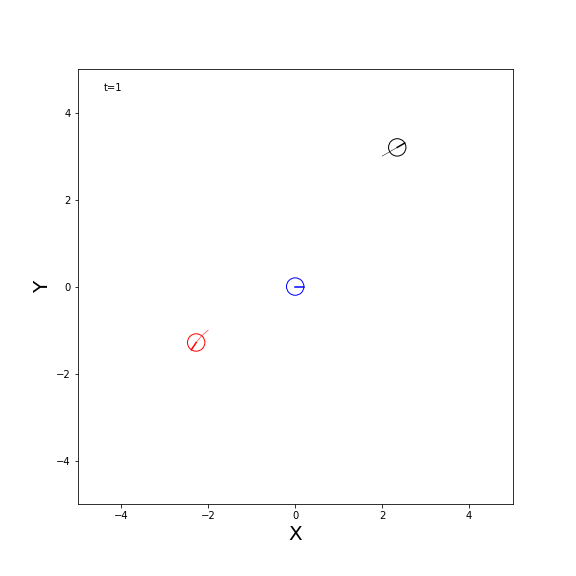

In [42]:
# 指令を与えるためのエージェントを実装したので使ってみる
reload()

world = worlds.World(debuggable=False)

straight = agents.Agent(0.2, 0.)
circling = agents.Agent(0.2, 10. / 180. * pi)

robot1 = robots.IdealRobot(
    np.array([2., 3., pi / 6.]).T, straight)
robot2 = robots.IdealRobot(
    np.array([-2., -1., pi /5. * 6.]).T, circling, 'red')
robot3 = robots.IdealRobot(
    np.array([0., 0., 0.]).T, color='blue')

world.append(robot1)
world.append(robot2)
world.append(robot3)

world.draw()